In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# from matplotlib.lines import Line2D
import seaborn as sns
import time

In [2]:
data = pd.read_csv('F:\Kuliah\Semester 7\Data Mining\Data Dow Jones\creditcard.csv', sep=',')
#data diambil dari kaggle.com/mlg-ulb/creditcardfraud

print (data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [3]:
data.shape

(284807, 31)

In [4]:
#print rangkuman statistik per feature
pd.options.display.float_format = "{:.6f}".format
data.describe(include='all')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,...,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000
mean,94813.859575,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,...,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,88.349619,0.001727
std,47488.145955,1.958696,1.651309,1.516255,1.415869,1.380247,1.332271,1.237094,1.194353,1.098632,...,0.734524,0.725702,0.624460,0.605647,0.521278,0.482227,0.403632,0.330083,250.120109,0.041527
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54201.500000,-0.920373,-0.598550,-0.890365,-0.848640,-0.691597,-0.768296,-0.554076,-0.208630,-0.643098,...,-0.228395,-0.542350,-0.161846,-0.354586,-0.317145,-0.326984,-0.070840,-0.052960,5.600000,0.000000
50%,84692.000000,0.018109,0.065486,0.179846,-0.019847,-0.054336,-0.274187,0.040103,0.022358,-0.051429,...,-0.029450,0.006782,-0.011193,0.040976,0.016594,-0.052139,0.001342,0.011244,22.000000,0.000000
75%,139320.500000,1.315642,0.803724,1.027196,0.743341,0.611926,0.398565,0.570436,0.327346,0.597139,...,0.186377,0.528554,0.147642,0.439527,0.350716,0.240952,0.091045,0.078280,77.165000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


In [5]:
print('No Frauds', round(data['Class'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Frauds', round(data['Class'].value_counts()[1]/len(data) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

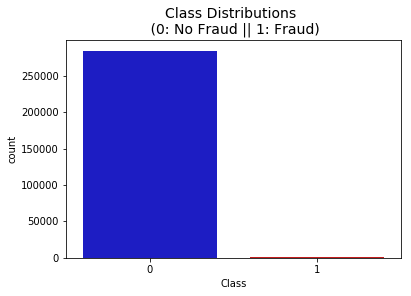

In [6]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=data, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

In [7]:
data.groupby('Class').size()

Class
0    284315
1       492
dtype: int64

In [8]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler menghilangkan median dan men-scale data berdasarkan quartile range-nya
# StandardScaler menghilangkan mean dan men-scale data ke unit variance

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

data['scaled_amount'] = std_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
#data['scaled_time'] = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))

data.drop(['Time','Amount'], axis=1, inplace=True)

#mengubah nama kolom Time Amount menjadi scaled_time dan scaled_amount
scaled_amount = data['scaled_amount']
#scaled_time = data['scaled_time']

data.drop(['scaled_amount'], axis=1, inplace=True)
data.insert(0, 'scaled_amount', scaled_amount)
#data.insert(1, 'scaled_time', scaled_time)

data.head()

,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.244964,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.342475,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.160686,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,0.140534,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.073403,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [9]:
pd.options.display.float_format = "{:.6f}".format
data.describe(include='all')

,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
count,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,...,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000
mean,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,...,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.001727
std,1.000002,1.958696,1.651309,1.516255,1.415869,1.380247,1.332271,1.237094,1.194353,1.098632,...,0.770925,0.734524,0.725702,0.624460,0.605647,0.521278,0.482227,0.403632,0.330083,0.041527
min,-0.353229,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000
25%,-0.330840,-0.920373,-0.598550,-0.890365,-0.848640,-0.691597,-0.768296,-0.554076,-0.208630,-0.643098,...,-0.211721,-0.228395,-0.542350,-0.161846,-0.354586,-0.317145,-0.326984,-0.070840,-0.052960,0.000000
50%,-0.265271,0.018109,0.065486,0.179846,-0.019847,-0.054336,-0.274187,0.040103,0.022358,-0.051429,...,-0.062481,-0.029450,0.006782,-0.011193,0.040976,0.016594,-0.052139,0.001342,0.011244,0.000000
75%,-0.044717,1.315642,0.803724,1.027196,0.743341,0.611926,0.398565,0.570436,0.327346,0.597139,...,0.133041,0.186377,0.528554,0.147642,0.439527,0.350716,0.240952,0.091045,0.078280,0.000000
max,102.362243,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,1.000000


In [10]:
fraud_data_all = data.loc[data['Class'] == 1]
nonFraud_data_all = data.loc[data['Class']==0]

#menggabungkan data fraud dan non-fraud
normal_distributed_data_all = pd.concat([fraud_data_all, nonFraud_data_all])
normal_distributed_data_all.shape
#normal_distributed_data_all.head()
# data2.head()
#fraud_data_all.shape

X = normal_distributed_data_all.drop('Class', axis=1)
y = normal_distributed_data_all['Class']
#X2 --> variabel label untuk prediksi
#y2 --> variabel feature, semua kolom kecuali X (Class)
#Memecah dataframe baru menjadi training dan test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [11]:
print ("Rincian class pada data training {} dan testing {} " .format(Counter(y_train), Counter(y_test)))

Rincian class pada data training Counter({0: 199013, 1: 351}) dan testing Counter({0: 85302, 1: 141}) 


In [12]:
X_train.shape

(199364, 29)

In [13]:
X_test.shape

(85443, 29)

In [14]:
X_train['Class'] = y_train

C:\Users\Muhsin Ahadi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
non_fraud = X_train.loc[X_train['Class']==0]
fraud = X_train.loc[X_train['Class']==1]

non_fraud_points = non_fraud.drop('Class', axis = 1)
fraud_points = fraud.drop('Class', axis = 1)

non_fraud_points=np.array(non_fraud_points)
fraud_points = np.array (fraud_points)

In [16]:
from scipy.spatial import distance
Y = distance.cdist(fraud_points, non_fraud_points, 'euclidean')

#mengurutkan hasil secara ascending
K = np.argsort(Y)
# print (Y)
# print ("Urutan data: \n", K)
Y.sort()
print ("After short: \n", Y[:,0:20])
Y.shape

After short: 
 [[ 6.82818331  7.47620016  7.86436073 ... 10.50909504 10.72451573
  10.8101345 ]
 [ 8.73578532  8.79917862  8.84552098 ... 12.8708253  13.55778197
  14.20511912]
 [11.68300106 11.7266043  11.76214233 ... 24.40287882 25.14327285
  25.50275859]
 ...
 [ 8.19377262  8.41309275  8.59817616 ... 15.04533289 15.08308453
  15.14482053]
 [12.74893675 12.88238467 12.92861333 ... 23.55947189 24.03521269
  24.32941118]
 [ 1.08603876  1.11818706  1.16408519 ...  1.61703646  1.62676372
   1.65383014]]


(351, 199013)

In [17]:
array_new = np.array(non_fraud_points[K[:,0:20]])
array_new.shape
XX= array_new.transpose(0,1,2).reshape(array_new.shape[0]*array_new.shape[1],29)
# XX
zeros_value = np.zeros((array_new.shape[0]*array_new.shape[1],1))
new_X = np.concatenate ((XX, zeros_value), axis=1)

print (new_X.shape)
new_X= np.unique(new_X,axis=0)
print (new_X.shape)

(7020, 30)
(1574, 30)


In [18]:
array_minority = np.array(fraud)
joined_resampling = np.concatenate((array_minority,new_X), axis=0)

X_resample = joined_resampling[:,0:29]
# X_resample = std_scaler.fit_transform(X_resample)
y_resample = joined_resampling[:,29]
# print (y)

print ('Setelah undersampling, komponen data: {}' .format(Counter(y_resample)))

Setelah undersampling, komponen data: Counter({0.0: 1574, 1.0: 351})


In [34]:
from sklearn.neighbors import KNeighborsClassifier
start = time.time()
knn = KNeighborsClassifier(n_neighbors=7, metric='euclidean')
knn.fit(X_resample, y_resample)
finish = time.time()
X_resample.shape
print ("Waktu: {}" .format(finish-start))

Waktu: 0.007004976272583008


In [35]:
from sklearn.metrics import confusion_matrix

y_pred = knn.predict(X_resample)
conf_matrix_train = confusion_matrix(y_resample, y_pred)
print (conf_matrix_train)
# print (X.shape)
print ("Classification Report:", '\n', classification_report_imbalanced(y_resample, y_pred))

[[1553   21]
 [  75  276]]
Classification Report: 
                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.95      0.99      0.79      0.97      0.88      0.79      1574
        1.0       0.93      0.79      0.99      0.85      0.88      0.76       351

avg / total       0.95      0.95      0.82      0.95      0.88      0.79      1925



In [36]:
X_test['Class'] = y_test
non_fraud2 = X_test.loc[X_test['Class']==0]
fraud2 = X_test.loc[X_test['Class']==1]

non_fraud2_points2 = non_fraud2.drop('Class', axis = 1)
fraud2_points2 = fraud2.drop('Class', axis = 1)

non_fraud2_points2=np.array(non_fraud2_points2)
fraud2_points2 = np.array (fraud2_points2)

zeros_value2 = np.zeros((non_fraud2_points2.shape[0],1), dtype=np.int8)

new_non_fraud = np.concatenate((non_fraud2_points2, zeros_value2), axis=1)

array_majority2 = np.array(fraud2)
joined_testing =np.concatenate ((array_majority2, new_non_fraud), axis =0)

X_test_new = joined_testing[:,0:29]
# X_test_new = rob_scaler.fit_transform(X_test_new)
y_test_new = joined_testing[:,29]


print (X_test_new.shape)
print ("Rincian class pada data  testing {} " .format(Counter(y_test_new)))

(85443, 29)
Rincian class pada data  testing Counter({0.0: 85302, 1.0: 141}) 


C:\Users\Muhsin Ahadi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
start = time.time()
y_pred_test = knn.predict(X_test_new)
conf_matrix_test = confusion_matrix(y_test_new, y_pred_test)
print (conf_matrix_test)
# print (X.shape)
print ("Classification Report:", '\n', classification_report_imbalanced(y_test_new, y_pred_test))
finish = time.time()
print ("Waktu: {}" .format(finish-start))

[[85288    14]
 [   31   110]]
Classification Report: 
                    pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      1.00      0.78      1.00      0.88      0.80     85302
        1.0       0.89      0.78      1.00      0.83      0.88      0.76       141

avg / total       1.00      1.00      0.78      1.00      0.88      0.80     85443

Waktu: 16.39888095855713


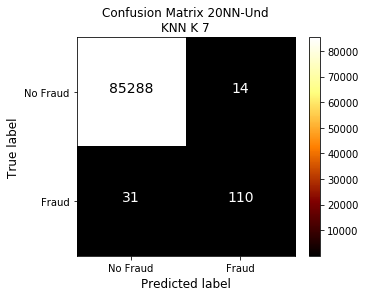

In [38]:


#log
#mengganti testing setnya dengan testing set untuk data keseluruhan
knn_cf = confusion_matrix(y_test_new, y_pred_test)

import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white",fontsize=14)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(5,4))

plot_confusion_matrix(knn_cf, labels, title="Confusion Matrix 20NN-Und\nKNN K {}" .format(knn.n_neighbors), cmap=plt.cm.afmhot)